In [ ]:
!pip install pyyaml==5.4.1
!pip install darts

In [ ]:
import time
import random
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import cpu_count, Pool # for prophet
from itertools import product
import os
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy.signal import lombscargle, periodogram
import darts
from darts import TimeSeries
from darts.models import AutoARIMA
from darts.metrics import mape
from darts.utils.statistics import plot_acf, extract_trend_and_seasonality, plot_hist, check_seasonality
from statsmodels.tsa.ar_model import AutoReg
import torch
import statistics
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# helper functions
patient_ids = [183, 184,  14, 220, 233,  62,  17, 186,  52, 216, 115,  37, 244,
       167, 265,  81, 113, 248,  76,  21,  79, 132, 215, 223, 110,  19,
       260, 289,  54,  64, 232, 172,  45, 203, 119,  31,  24, 156, 276,
       162, 240, 239,  32, 236,  73,  26, 205,  48, 267,   2, 256, 141,
         8,  22, 204, 163,  42, 226, 251, 198, 165,  60, 264, 241, 138,
        67,  90, 206,  38, 266, 281,  10,  41, 185,  35, 140, 283, 118,
        80, 123, 217,  39, 160, 112,  50, 292, 164, 246,  18, 128, 103,
       210,   9,  71, 169,  65, 166,  74,  96, 134, 271,  55, 228, 234,
       155, 139,  95,   7,  11,  61, 250, 168, 108, 252, 106,  68, 213,
       127,  36, 176, 273, 130, 136, 152,  53, 193, 243, 253, 148, 135,
       274, 287, 231, 105, 201,   3, 200, 245,  91,  98, 101, 137,  70,
       219, 121, 143,  23, 109, 263,  46, 229,  93, 188,  72, 190, 211,
       218,  77, 181, 288, 278,  87, 173,  47,  33, 277, 224,  43, 257,
        69, 175,  58, 124,  78, 116, 146,  49,  30,  16,  86,   5, 158,
       171, 179, 258, 284, 170, 147, 249,  97, 131, 272, 285, 174, 222,
       102, 221,  15,  89,  57,  82,  29, 214, 149, 227,  20, 280, 247,
       269, 157,  40, 293, 145, 197,  27, 187, 254, 235, 209, 129, 177,
       291, 189, 290, 275, 111]
def downcast_to_float_32(df):
    df['GlucoseValue'] = df['GlucoseValue'].astype(np.float32)
    df['TotalDeviceMinutes'] = df['TotalDeviceMinutes'].astype(np.float32)
    df['TotalInternalHours_Diff'] = df['TotalInternalHours_Diff'].astype(np.float32)
    return df

def get_all_resampled_patient_timeseries(patient_dfs, value_column = "GlucoseValue"):
  all_patient_timeseries = []
  for df in patient_dfs: 
    individual_patient_timeseries = TimeSeries.from_dataframe(df, value_cols = [value_column]) 
    all_patient_timeseries.append(individual_patient_timeseries)
  return all_patient_timeseries

def get_resampled_patient_dfs(): 
  resampled_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'/content/drive/MyDrive/Colab Notebooks/data/resampled/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    resampled_patient_dfs.append(df)
  return resampled_patient_dfs

def get_filtered_patient_dfs(): 
  filtered_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'/content/drive/MyDrive/Colab Notebooks/data/filtered/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    filtered_patient_dfs.append(df)
  return filtered_patient_dfs

def plot_forecast(series_train, series_forecast, mape, ax):
  series_train.plot(label="actual", ax=ax)
  series_forecast.plot(label="forecast", ax=ax)
  plt.legend()
  print("MAPE = {:.2f}%".format(mape))

def get_rolling_30min_prediction(test_timeseries, model): 
  # give ourselves a large birth incase we have seasonality with a high value of s
  input_chunk_length = 50 
  last_predictable_timestep = len(resampled_patient_timeseries_train[0]) - input_chunk_length - 1
  prediction_range = range(input_chunk_length+1, last_predictable_timestep, 1)
  predictions = []
  for prediction_window_end_index in prediction_range: 
    print(f"start index = {prediction_window_end_index-input_chunk_length}")
    print(f"stop index = {prediction_window_end_index}")
    prediction_timesereies_window = test_timeseries[prediction_window_end_index-input_chunk_length:prediction_window_end_index]
    prediction = model.predict(n=1, series=prediction_timesereies_window, verbose=False, n_jobs=8)
    predictions.append(prediction)
  return predictions, test_timeseries[input_chunk_length+1:last_predictable_timestep]

In [ ]:
# resampled data 
resampled_patient_dfs = get_resampled_patient_dfs()
# use 50/50 for test/train for now
train_cutoff_index = round(len(resampled_patient_dfs)/2)

# dfs
resampled_patient_dfs_train = resampled_patient_dfs[:train_cutoff_index]
resampled_patient_dfs_test = resampled_patient_dfs[train_cutoff_index:]

# time-series
resampled_patient_timeseries_train = get_all_resampled_patient_timeseries(resampled_patient_dfs_train, "GlucoseValue")
resampled_patient_timeseries_test = get_all_resampled_patient_timeseries(resampled_patient_dfs_test, "GlucoseValue")

ARIMA - Traditional 

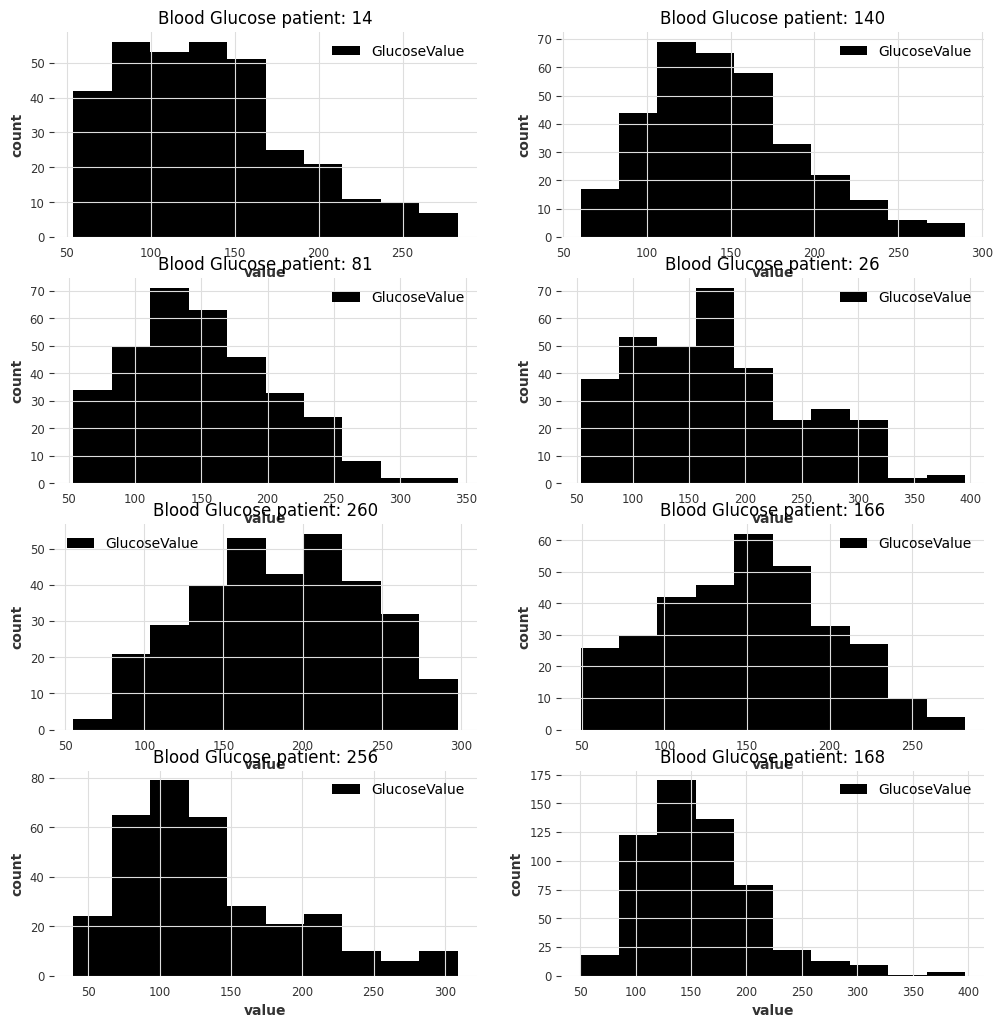

In [ ]:
# plot some blood glucose distributions - TODO: ADD this to EDA Notebook!
fig, axes = plt.subplots(4,2, figsize=(12,12.5), dpi=100)
plot_hist(resampled_patient_timeseries_train[2], title = f"Blood Glucose patient: {patient_ids[2]}", ax=axes[0, 0])
plot_hist(resampled_patient_timeseries_train[15], title = f"Blood Glucose patient: {patient_ids[15]}", ax=axes[1, 0])
plot_hist(resampled_patient_timeseries_train[26], title = f"Blood Glucose patient: {patient_ids[26]}", ax=axes[2, 0])
plot_hist(resampled_patient_timeseries_train[50], title = f"Blood Glucose patient: {patient_ids[50]}", ax=axes[3, 0])
plot_hist(resampled_patient_timeseries_train[75], title = f"Blood Glucose patient: {patient_ids[75]}", ax=axes[0, 1])
plot_hist(resampled_patient_timeseries_train[45], title = f"Blood Glucose patient: {patient_ids[45]}", ax=axes[1, 1])
plot_hist(resampled_patient_timeseries_train[96], title = f"Blood Glucose patient: {patient_ids[96]}", ax=axes[2, 1])
plot_hist(resampled_patient_timeseries_train[111], title = f"Blood Glucose patient: {patient_ids[111]}", ax=axes[3, 1])

We can see that there are different distributions of values per patient. However, on average glucose does appear to right skewed. This might suggest a log transform to be useful. The skew doesn't appear to be extreme though. To keep things simple, and more interpretable, lets leave the glucose values alone (no transform). 


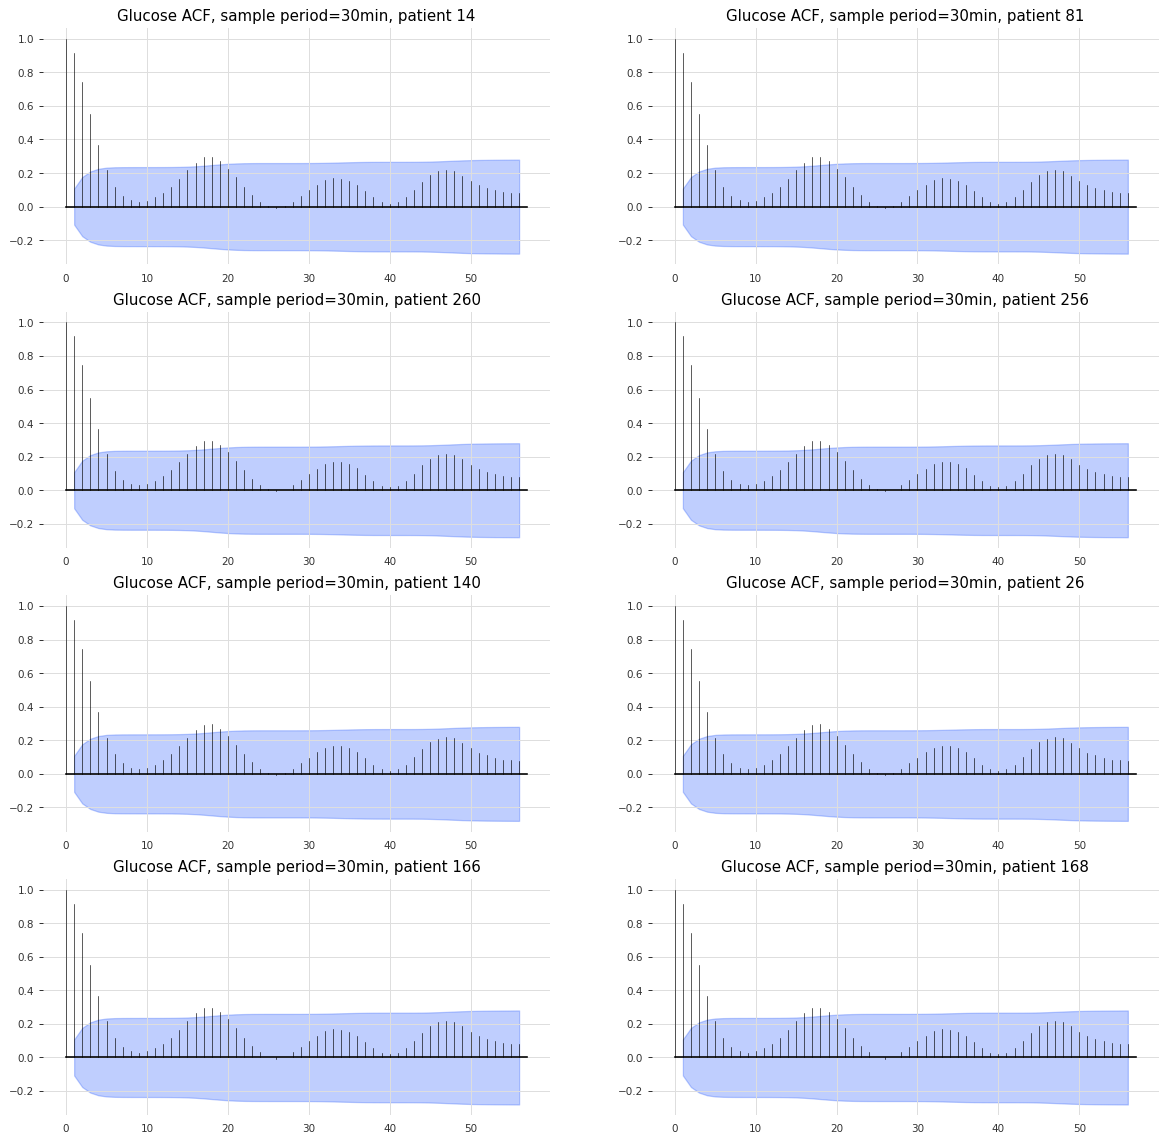

In [ ]:
# plot some blood glucose acf's
fig, axes = plt.subplots(4,2, figsize=(16,16), dpi=90)
patient_id_indices = [2, 15, 26, 50, 75, 45, 96, 111]

for patient_id_index, (idx, idy) in zip(patient_id_indices, product(range(4), range(2))): 
  axes[idx, idy].set_title(f"Glucose ACF, sample period=30min, patient {patient_ids[patient_id_index]}")
  plot_acf(resampled_patient_timeseries_train[2], axis=axes[idx, idy], max_lag=56)

We can see that there is some wandering, but also some periodicity (at varying periods) across the various glucose time-series. This probably reflects the varying meal frequency of different patients. We can also use domain knowledge to assume that, while there is strong positive correlation between glucose values (for at least 2 hours), values will never wander beyond 400 (the upper CGM limit) and below 0. We also know that glucose values depend heavily on indidual meals and insulin dosing, thus we can assume that each patient realization will be random WRT to one another (not predictable, like a sine wave).

 As far as seasonality, we can it is reasonable to expect either a rough ~24 hour seasonality (daily meal seasonality) or even a ~3 hour seasonality (between meals). We could overfit with AR and explore the overfit factor tables to be sure of seasonal factors with factors near the unit circle. 
 
 
 
 
 Let's first intentionally overfit with AR on a series of training data, analyze the roots, and decide if there is any 1-B component which is consistent across the fits.

In [ ]:
for i in range(0,4):
  print("==================================")
  print(f"========== OVERFIT AR - Model {i} =====")
  print("==================================")
  overfit_ar_model = AutoReg(resampled_patient_dfs_train[i]['GlucoseValue'], lags=50).fit()
  print(overfit_ar_model.summary())

========== OVERFIT AR - Model 0 =====
                            AutoReg Model Results                             
Dep. Variable:           GlucoseValue   No. Observations:                  333
Model:                    AutoReg(50)   Log Likelihood               -1160.750
Method:               Conditional MLE   S.D. of innovations             14.624
Date:                Thu, 05 May 2022   AIC                           2425.500
Time:                        04:49:36   BIC                           2615.063
Sample:                    07-19-1970   HQIC                          2501.508
                         - 07-25-1970                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               26.3595     10.136      2.601      0.009       6.494      46.225
GlucoseValue.L1      1.5782      0.058     27.011      0.000       1.464   

It appears that there are MANY factors with roots outside the unit circle which dominate in the signal. As expected, none of these have a system frequency of 0, which backs up our domain driven assumption that glucose values CANNNOT wander outside of certain values (for someone who is still alive). 

Further and surprisingly, the MOST dominant roots for each training patient glucose timeseries,  all seem to share system frequencies of 0.5. This suggests pure oscillation in the signal. My hunch is that there is seasonality, and that it is a higher order seasonality which is composed of common factors.

The takeaway here is that the data does NOT appear stationary due to seasonality present in the data (personal meal patterns exist!).

:Next fit an AutoARIMA with "bic" to identify the phi, theta, s, & d. :

In [ ]:
%time
# fit an auto-arima model, using "bic" to prefer more parsimonious models
kwargs = {
    "information_criterion": "bic"
}

arima_models = []
for i, individual_patient_timeseries in enumerate(resampled_patient_timeseries_train): 
  print("==================================")
  print(f"========== SARIMAX - Model {i} =====")
  print("==================================")
  autoarima_model = AutoARIMA(**kwargs)
  autoarima_model.fit(individual_patient_timeseries)
  print(autoarima_model.model.summary())
  arima_models.append(autoarima_model)

  if i > 5: 
    break

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
========== SARIMAX - Model 0 =====
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  333
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1397.764
Date:                Thu, 05 May 2022   AIC                           2805.527
Time:                        04:57:19   BIC                           2824.568
Sample:                             0   HQIC                          2813.120
                                - 333                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.5682      4.788      5.340      0.000      16.185      34.952
ar.L1          1.0146      0.063

We note that for the the first SARIMAX (SARIMAX 0) the  Ljung-Box residual test for whitenoise, CAN reject the possibility of the residuals being white noise. As such, correlation is still present in the data. HOWEVER, forthe next glucose timeseries (SARIMAX 1), we CANNOT reject whitenoise in the residuals, suggesting correlation entropy has been effectively captured. This suggests that the best SARIMA for each patient varies somewhat signifigantly.  

In [ ]:
# find the best performing arima across our training data. 
best_arima_model = None
for arima_model in arima_models:
  last_point_train_mapes = []
  for i, individual_resampled_patient_timeseries_train in enumerate(resampled_patient_timeseries_train):
    if(i>= 5):
      break

    stride = round(len(individual_resampled_patient_timeseries_train)/10) # stride width = 1/10th the timeseries each time. 
    last_point_mape = arima_model.backtest(individual_resampled_patient_timeseries_train, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, verbose=False)
    last_point_train_mapes.append(last_point_mape)
  current_model_mape = statistics.mean(last_point_train_mapes)
  if(current_model_mape < best_mean_arima_mape): 
    best_mean_arima_mape = current_model_mape
    best_arima_model = arima_model

print(f"Best MEAN ABSOLUTE PERCENTAGE ERROR was: {best_mean_arima_mape}")

Best MEAN ABSOLUTE PERCENTAGE ERROR was: 9.394758523617693


In [ ]:
# Model Evaluation: Train 
# GET MAPE and Historical Predictions
last_point_historical_predictions_train = []
train_mapes = []
for i, individual_resampled_patient_timeseries_train in enumerate(resampled_patient_timeseries_train):
  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_train)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = best_arima_model.backtest(individual_resampled_patient_timeseries_train, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=True, verbose=False)
  train_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = best_arima_model.historical_forecasts(individual_resampled_patient_timeseries_train, start=0.5, forecast_horizon=1, stride=1, last_points_only=True, retrain=True, verbose=False)
    last_point_historical_predictions_train.append(last_point_predictions)

In [ ]:
print(f"Mean MAPE for first 20 train patients was: {statistics.mean(train_mapes)}%")
print(best_arima_model.model.summary())

Mean MAPE for first 20 train patients was: 10.427233626439019%
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  330
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1383.903
Date:                Thu, 05 May 2022   AIC                           2775.806
Time:                        06:34:28   BIC                           2791.002
Sample:                             0   HQIC                          2781.867
                                - 330                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.3678      4.634      4.179      0.000      10.284      28.451
ar.L1          0.8647      0.030     28.449      0.000       0.805  

We can see that the best model is actually a SARIMAX(1,0,1). This is somewhat simple. However, it is a little bit trickier (than a pure AR model) to explain due to the MA(q=1) component. 

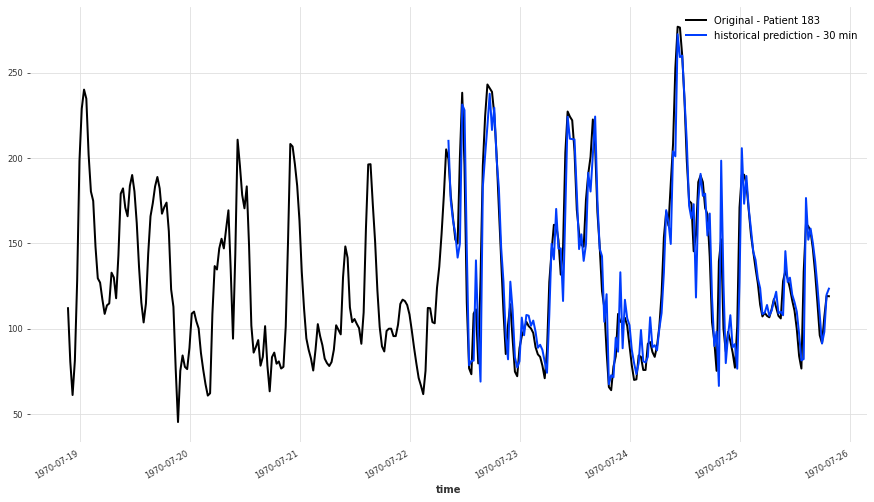

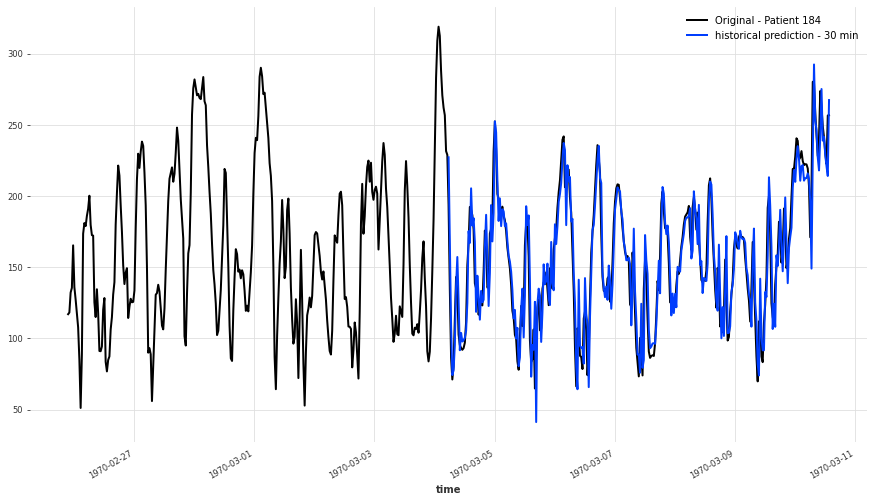

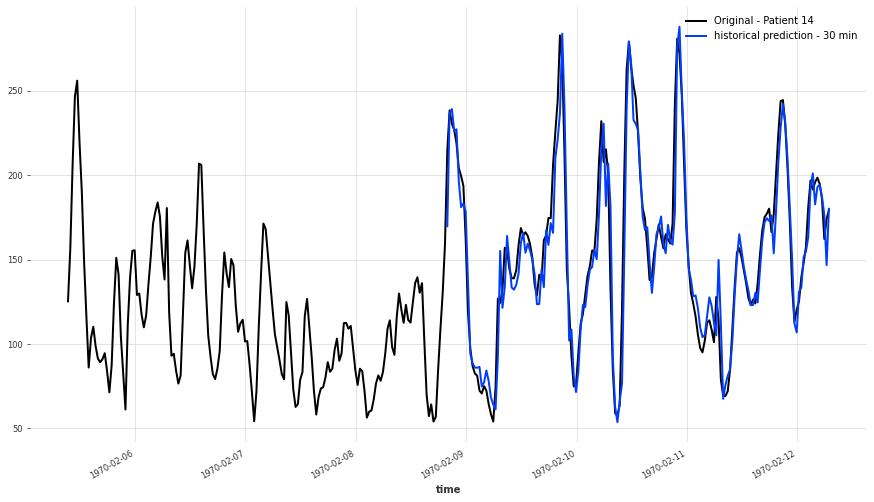

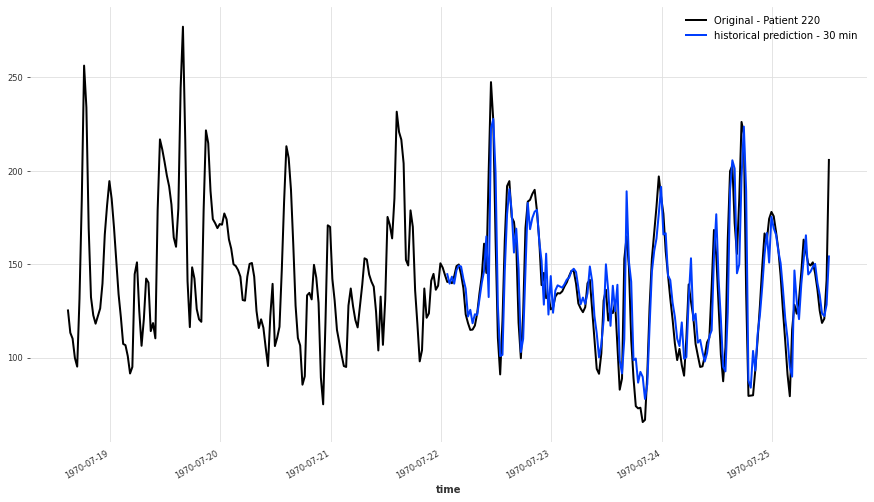

In [ ]:
# Train Historical Prediction plot
index = 0 
for patient_id_index in range(0, 4):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_train[patient_id_index].plot(label=f"Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_train[patient_id_index].plot(label="historical prediction - 30 min")

Summarizing the arima analysis, it is a bit of a different beast from other models that were tried. The MAPE (for trained data) is roughly 10.42%. However, because it is VERY fast to train an ARIMA model on a given dataset, and because THE given parameter estimates for an ARIMA(1,0,1) doesn't usually generalize super well to other time series, it actually makes the most sense to use the model produced by our SARIMAX's values for p, q, s, and d but to train the model individually per patient to get personalized SARIMA predictions. 

Future steps would be to explore multivariate relationships with other data, like insulin, with Vector Auto SARIMAX. 